 # Employee Attrition Prediction Using Classification

This project explores factors leading to employee attrition using machine learning models with interpretability and evaluation across multiple stages.


## Load and Explore the Data

* **Objective:** Import the dataset, understand feature distributions, and check class balance.
* **Key Insight:** 16.1% of employees have left the organization, indicating a class imbalance problem.


In [1]:
import pandas as pd
import os

# Verify current working directory
print("Running in:", os.getcwd())


# Load the dataset
try:
    df = pd.read_csv("../Employee-Attrition-Prediction/Dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv")
    print(f"\nDataset loaded {df.shape[0]} rows and {df.shape[1]} columns successfully.")
except FileNotFoundError:
    print("Error: Dataset file not found. Please check the file path.")



# Display a preview of the dataset
print("\nPreview of the dataset:")
print(df.head())

# Display dataset information
print("\nDataset Information:")
print(df.info())

# Display statistical summary
print("\nStatistical Summary:")
print(df.describe())

# Check for missing values
print("\nMissing Values per Column:")
print(df.isnull().sum())

print("\nDuplicate rows:", df.duplicated().sum())

Running in: /Users/EndUser/Desktop/Projects/Employee-Attrition-Prediction

Dataset loaded 1470 rows and 35 columns successfully.

Preview of the dataset:
   Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4

## Preprocessing + Train/Test Split

* **Steps:**

  * Define features `X` and target `y` (converted from `"Yes"/"No"` to 1/0).
  * Split the data into training and testing sets.
* **Notes:** Stratification was avoided to prevent tiny-class errors during splits.


Dataset size: (1470, 32)
Attrition value counts:
 Attrition
No     1233
Yes     237
Name: count, dtype: int64 

16.1% attrition rate



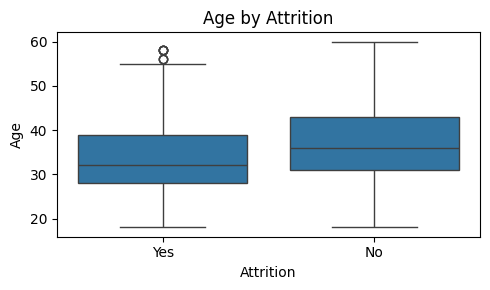

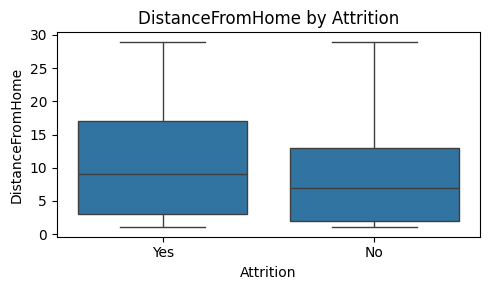

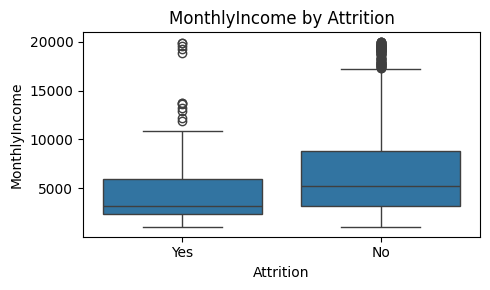

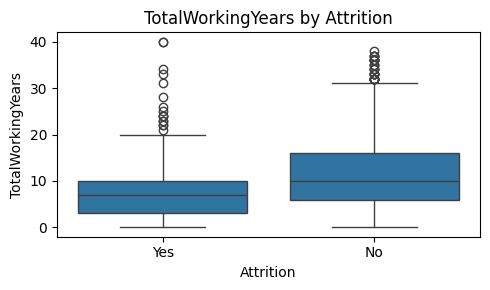

Top positive correlations:
 AttritionFlag         1.000000
DistanceFromHome      0.077924
NumCompaniesWorked    0.043494
MonthlyRate           0.015170
PerformanceRating     0.002889
Name: AttritionFlag, dtype: float64 

Top negative correlations:
 Age                  -0.159205
MonthlyIncome        -0.159840
YearsInCurrentRole   -0.160545
JobLevel             -0.169105
TotalWorkingYears    -0.171063
Name: AttritionFlag, dtype: float64 



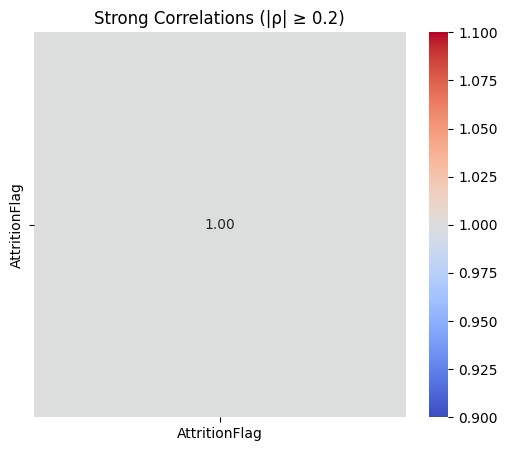

BusinessTravel vs Attrition: χ²=24.2, p=0.000

Attrition rates by BusinessTravel:
                    Stayed  Left   Rate (%)
BusinessTravel                            
Non-Travel            138    12   8.000000
Travel_Frequently     208    69  24.909747
Travel_Rarely         887   156  14.956855 



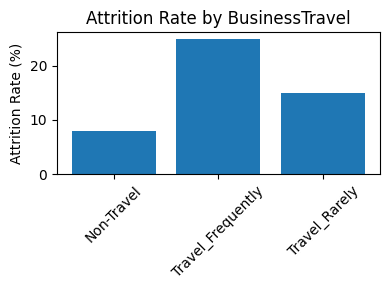

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# 1. Drop constants/IDs
drop_cols = ['EmployeeCount', 'StandardHours', 'Over18', 'EmployeeNumber']
df_clean = df.drop(columns=drop_cols)

# 2. Encode target for analysis
df_clean['AttritionFlag'] = df_clean['Attrition'].map({'Yes':1, 'No':0})

# 3. Class balance
print(f"Dataset size: {df_clean.shape}")
print("Attrition value counts:\n", df_clean['Attrition'].value_counts(), "\n")
print(f"{df_clean['AttritionFlag'].mean()*100:.1f}% attrition rate\n")

# 4. Boxplots for key numerics
for col in ['Age','DistanceFromHome','MonthlyIncome','TotalWorkingYears']:
    plt.figure(figsize=(5,3))
    sns.boxplot(x='Attrition', y=col, data=df_clean)
    plt.title(f"{col} by Attrition")
    plt.tight_layout()
    plt.show()

# 5. Correlations with AttritionFlag
corr = df_clean.corr(numeric_only=True)['AttritionFlag'].sort_values(ascending=False)
print("Top positive correlations:\n", corr.head(5), "\n")
print("Top negative correlations:\n", corr.tail(5), "\n")

# 6. Strong‐corr heatmap (|ρ| ≥ 0.2)
strong = df_clean.select_dtypes(include=['int64','float64'])\
                 .corr().loc[corr.abs()>=0.2, corr.abs()>=0.2]
plt.figure(figsize=(6,5))
sns.heatmap(strong, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Strong Correlations (|ρ| ≥ 0.2)")
plt.show()

# 7. Chi-square & attrition rates for BusinessTravel
ct = pd.crosstab(df_clean['BusinessTravel'], df_clean['Attrition'])
chi2, p, *_ = chi2_contingency(ct)
print(f"BusinessTravel vs Attrition: χ²={chi2:.1f}, p={p:.3f}\n")

ct2 = pd.crosstab(df_clean['BusinessTravel'], df_clean['AttritionFlag'])
ct2.columns = ['Stayed','Left']
ct2['Rate (%)'] = ct2['Left']/(ct2['Stayed']+ct2['Left'])*100
print("Attrition rates by BusinessTravel:\n", ct2, "\n")

plt.figure(figsize=(4,3))
plt.bar(ct2.index, ct2['Rate (%)'])
plt.xticks(rotation=45)
plt.ylabel("Attrition Rate (%)")
plt.title("Attrition Rate by BusinessTravel")
plt.tight_layout()
plt.show()


## Preprocessing → Oversampling → PCA

* **Steps:**

  * Numerical features scaled; categorical features one-hot encoded.
  * Used **manual oversampling** to balance classes in training data.
  * Applied **PCA** to retain 95% variance and reduce dimensionality.
* **Output:** Final `X_train_pca` and `X_test_pca` for downstream modeling.


In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.utils import resample

# 1. Define X, y (binary target)
y = (df['Attrition']=='Yes').astype(int)
X = df.drop(columns=['Attrition'])

# 2. Split train/test (no stratify to avoid tiny-class errors)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Train class counts (0,1):", np.bincount(y_train))
print("Test  class counts (0,1):", np.bincount(y_test), "\n")

# 3. Preprocessing: scale numerics & one-hot encode categoricals
num_cols = ['Age','DistanceFromHome']
cat_cols = ['BusinessTravel','OverTime','MaritalStatus','JobRole']
preproc = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first'), cat_cols)
])
X_train_pre = preproc.fit_transform(X_train)
X_test_pre  = preproc.transform(X_test)

# Densify if sparse
if hasattr(X_train_pre, "toarray"):
    X_train_pre = X_train_pre.toarray()
    X_test_pre  = X_test_pre.toarray()

# 4. Manual up-sampling of the minority class in train set
train_df = pd.DataFrame(X_train_pre)
train_df['y'] = y_train.values
maj = train_df[train_df.y==0]
min_ = train_df[train_df.y==1]

min_up = resample(min_, replace=True,
                  n_samples=len(maj),
                  random_state=42)
balanced = pd.concat([maj, min_up]).sample(frac=1, random_state=42)
X_res, y_res = balanced.drop(columns='y').values, balanced['y'].values
print("Balanced train counts (0,1):", np.bincount(y_res), "\n")

# 5. PCA → 95% explained variance
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_res)
X_test_pca  = pca.transform(X_test_pre)
print("After PCA shapes →",
      "X_train:", X_train_pca.shape,
      "X_test:",  X_test_pca.shape)


Train class counts (0,1): [978 198]
Test  class counts (0,1): [255  39] 

Balanced train counts (0,1): [978 978] 

After PCA shapes → X_train: (1956, 10) X_test: (294, 10)


## Model Training & Evaluation

* **Model:** Logistic Regression with balanced class weights.
* **Output:**

  * Classification report
  * ROC-AUC score
  * ROC Curve plotted
* **Insight:** Logistic Regression performs moderately well with PCA features.

Classification Report:
              precision    recall  f1-score   support

        Stay       0.90      0.70      0.79       255
       Leave       0.21      0.51      0.30        39

    accuracy                           0.68       294
   macro avg       0.56      0.61      0.54       294
weighted avg       0.81      0.68      0.72       294

ROC-AUC = 0.649



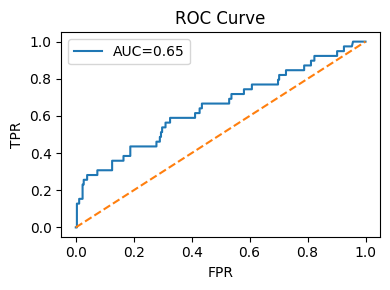

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Train a simple classifier
clf = LogisticRegression(class_weight='balanced', random_state=42, max_iter=500)
clf.fit(X_train_pca, y_res)

# 2. Predict & report
y_pred = clf.predict(X_test_pca)
y_prob = clf.predict_proba(X_test_pca)[:,1]

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Stay','Leave']))

# 3. ROC-AUC & curve
auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC = {auc:.3f}\n")

fpr,tpr,_ = roc_curve(y_test, y_prob)
plt.figure(figsize=(4,3))
plt.plot(fpr,tpr,label=f"AUC={auc:.2f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve")
plt.legend(); plt.tight_layout(); plt.show()


## Feature Selection with Random Forest

* **Steps:**

  * Used `pd.get_dummies()` to handle all features.
  * RandomForestClassifier trained on full feature space.
  * Top 10 important features extracted and plotted.
* **Result:** `top_features` list prepared for focused model training.

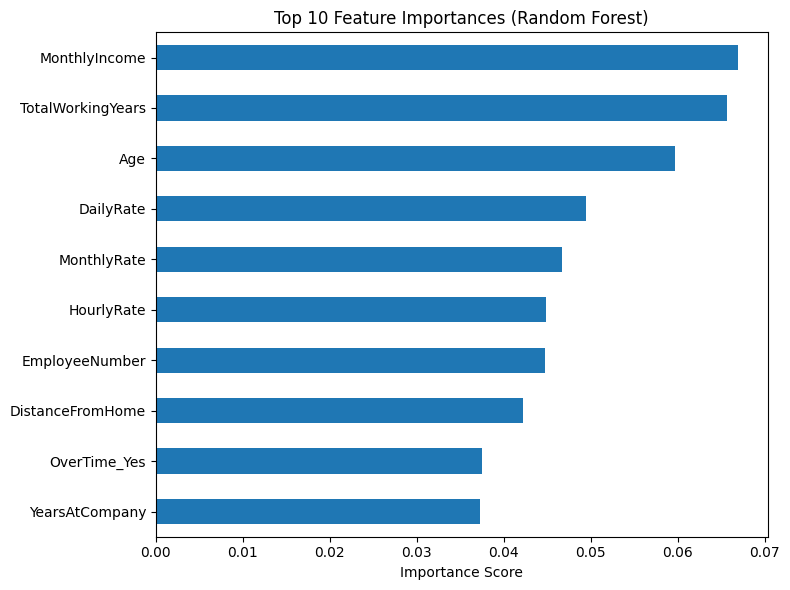

Top 10 selected features:
 ['MonthlyIncome', 'TotalWorkingYears', 'Age', 'DailyRate', 'MonthlyRate', 'HourlyRate', 'EmployeeNumber', 'DistanceFromHome', 'OverTime_Yes', 'YearsAtCompany']

Shape of X_train_top: (1176, 10)
Shape of X_test_top:  (294, 10)


In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

# 1. Prepare X_rf, y_rf with one-hot encoding for all predictors
X_rf = pd.get_dummies(
    df.drop(columns=['Attrition']),   # drop original target
    drop_first=True,
    dtype=int
)
y_rf = df['Attrition'].map({'Yes': 1, 'No': 0})

# 2. Split into train/test (preserving class balance)
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_rf, y_rf,
    test_size=0.2,
    stratify=y_rf,
    random_state=42
)

# 3. Train a Random Forest to compute importances
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

# 4. Extract and sort feature importances
importances = pd.Series(
    rf_model.feature_importances_,
    index=X_train_rf.columns
).sort_values(ascending=False)

# 5. Plot the top 10
plt.figure(figsize=(8, 6))
importances.head(10).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# 6. Select the top 10 features
top_features = importances.head(10).index.tolist()
print("Top 10 selected features:\n", top_features)

# 7. Subset train/test on these features
X_train_top = X_train_rf[top_features]
X_test_top  = X_test_rf[top_features]

# 8. Verify shapes
print("\nShape of X_train_top:", X_train_top.shape)
print("Shape of X_test_top: ", X_test_top.shape)


## Training Final Models with Top Features

* **Models Used:**

  * Logistic Regression
  * SVM (Support Vector Machine)
* **Steps:**

  * 5-fold cross-validation used to assess each model.
  * Accuracy used to normalize ensemble voting weights.
* **Result:** Trained models `logistic_model`, `svm_model`, and weight dictionary `weights`.


In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

# 1. Build pipelines with scaling
logistic_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('clf', LogisticRegression(
        penalty='l2',
        C=0.1,
        class_weight='balanced',
        solver='lbfgs',
        max_iter=5000,
        random_state=42))
])

svm_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('clf', SVC(
        kernel='rbf',
        class_weight='balanced',
        probability=True,    # ← enable probability estimates
        random_state=42))
])

# 2. Cross-validation on the top-feature training set
print("Cross-validated accuracy scores:")

log_cv_scores = cross_val_score(
    logistic_pipeline,
    X_train_top,
    y_train_rf,
    cv=5,
    scoring='accuracy'
)
logistic_acc = log_cv_scores.mean()
print(f"  Logistic Regression 5-fold CV Accuracy: {logistic_acc:.4f}")

svm_cv_scores = cross_val_score(
    svm_pipeline,
    X_train_top,
    y_train_rf,
    cv=5,
    scoring='accuracy'
)
svm_acc = svm_cv_scores.mean()
print(f"  SVM 5-fold CV Accuracy:                {svm_acc:.4f}")

# 3. Compute normalized model weights
model_accuracies = {'Logistic Regression': logistic_acc, 'SVM': svm_acc}
total_acc = sum(model_accuracies.values())
weights = {m: acc/total_acc for m, acc in model_accuracies.items()}
print("\nModel Weights (normalized by accuracy):")
for model_name, weight in weights.items():
    print(f"  {model_name}: {weight:.3f}")

# 4. Train final pipelines on the full top-feature training set
logistic_pipeline.fit(X_train_top, y_train_rf)
svm_pipeline.fit(X_train_top, y_train_rf)



Cross-validated accuracy scores:
  Logistic Regression 5-fold CV Accuracy: 0.6803
  SVM 5-fold CV Accuracy:                0.7432

Model Weights (normalized by accuracy):
  Logistic Regression: 0.478
  SVM: 0.522


Pipeline(steps=[('scale', StandardScaler()),
                ('clf',
                 SVC(class_weight='balanced', probability=True,
                     random_state=42))])

## Ensemble Prediction & Final Evaluation

* **Method:** Weighted-vote ensemble using predictions from both models.
* **Output:**

  * Individual and ensemble classification reports.
  * ROC-AUC score and ROC curve for ensemble.
* **Insight:** Ensemble can often outperform individual models via balanced vote.


Logistic Regression Test Report:
              precision    recall  f1-score   support

        Stay       0.92      0.67      0.77       247
       Leave       0.29      0.70      0.41        47

    accuracy                           0.67       294
   macro avg       0.60      0.69      0.59       294
weighted avg       0.82      0.67      0.72       294

SVM Test Report:
              precision    recall  f1-score   support

        Stay       0.90      0.77      0.83       247
       Leave       0.32      0.57      0.41        47

    accuracy                           0.74       294
   macro avg       0.61      0.67      0.62       294
weighted avg       0.81      0.74      0.76       294

Ensemble Test Report:
              precision    recall  f1-score   support

        Stay       0.90      0.77      0.83       247
       Leave       0.32      0.57      0.41        47

    accuracy                           0.74       294
   macro avg       0.61      0.67      0.62       294
we

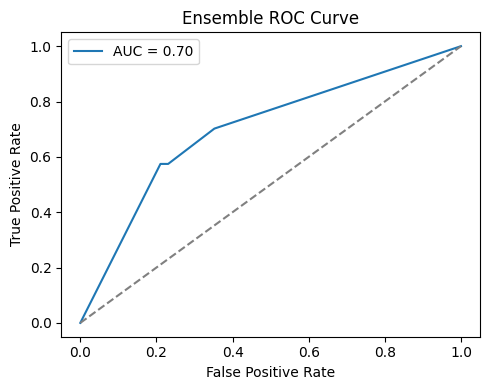

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, roc_curve


# 1. Individual test‐set predictions
lr_pred  = logistic_pipeline.predict(X_test_top)
svm_pred = svm_pipeline.predict(X_test_top)

# 2. Weighted‐vote ensemble
ensemble_score = (
    weights['Logistic Regression'] * lr_pred +
    weights['SVM']                  * svm_pred
)
ensemble_pred = (ensemble_score >= 0.5).astype(int)

# 3. Classification reports
print("Logistic Regression Test Report:")
print(classification_report(y_test_rf, lr_pred, target_names=['Stay','Leave']))

print("SVM Test Report:")
print(classification_report(y_test_rf, svm_pred, target_names=['Stay','Leave']))

print("Ensemble Test Report:")
print(classification_report(y_test_rf, ensemble_pred, target_names=['Stay','Leave']))

# 4. Ensemble ROC‐AUC and curve
auc = roc_auc_score(y_test_rf, ensemble_score)
print(f"Ensemble ROC‐AUC: {auc:.3f}\n")

fpr, tpr, _ = roc_curve(y_test_rf, ensemble_score)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0,1], [0,1], '--', color='gray')
plt.title("Ensemble ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()




Logistic Regression (threshold=0.3):
  Accuracy : 0.405
  Precision: 0.198
  Recall   : 0.894
  F1-Score : 0.324
  ROC AUC  : 0.724


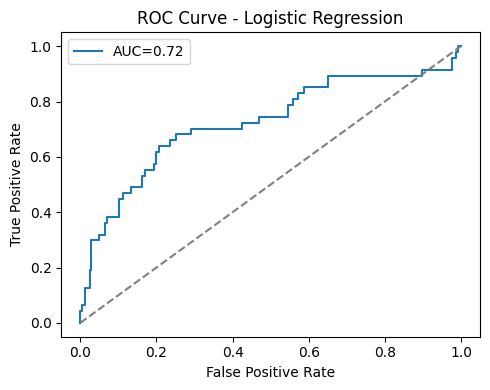

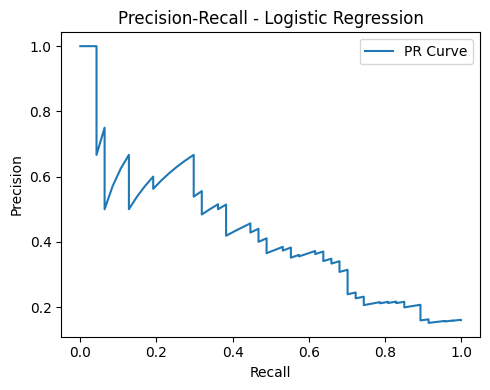


SVM (threshold=0.5):
  Accuracy : 0.857
  Precision: 1.000
  Recall   : 0.106
  F1-Score : 0.192
  ROC AUC  : 0.733


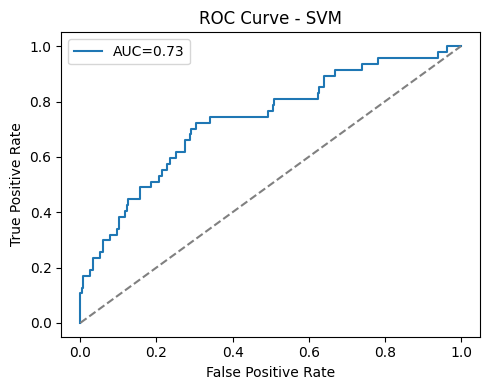

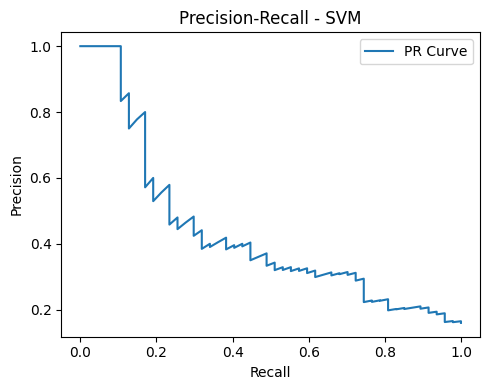


Combined Model Evaluation:
  Accuracy : 0.833
  Precision: 0.472
  Recall   : 0.362
  F1-Score : 0.410
  ROC AUC  : 0.723


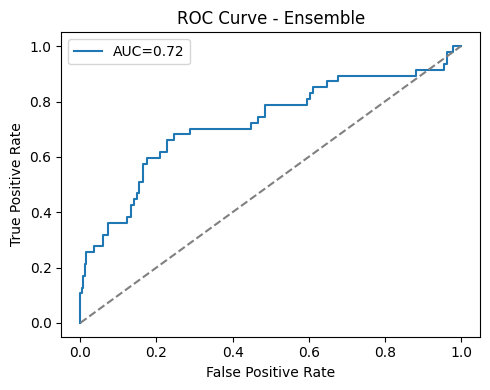

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    classification_report
)

# 1. Evaluation function
def evaluate_model(model, X, y, name, threshold=0.5):
    proba = model.predict_proba(X)[:, 1]
    pred  = (proba >= threshold).astype(int)
    print(f"\n{name} (threshold={threshold}):")
    print(f"  Accuracy : {accuracy_score(y, pred):.3f}")
    print(f"  Precision: {precision_score(y, pred, zero_division=1):.3f}")
    print(f"  Recall   : {recall_score(y, pred):.3f}")
    print(f"  F1-Score : {f1_score(y, pred):.3f}")
    print(f"  ROC AUC  : {roc_auc_score(y, proba):.3f}")

    # ROC Curve
    fpr, tpr, _ = roc_curve(y, proba)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y, proba):.2f}")
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.title(f"ROC Curve - {name}")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.legend(); plt.tight_layout(); plt.show()

    # Precision-Recall Curve
    pr, rc, _ = precision_recall_curve(y, proba)
    plt.figure(figsize=(5,4))
    plt.plot(rc, pr, label=f"PR Curve")
    plt.title(f"Precision-Recall - {name}")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.legend(); plt.tight_layout(); plt.show()

# 2. Evaluate individual models
evaluate_model(logistic_pipeline, X_test_top, y_test_rf, "Logistic Regression", threshold=0.3)
evaluate_model(svm_pipeline,      X_test_top, y_test_rf, "SVM")

# 3. Weighted ensemble probabilities
def weighted_proba(models, weights, X):
    w = np.zeros(X.shape[0])
    for name, model in models.items():
        w += weights[name] * model.predict_proba(X)[:,1]
    return w

models = {
    "Logistic Regression": logistic_pipeline,
    "SVM": svm_pipeline
}
ensemble_proba = weighted_proba(models, weights, X_test_top)
ensemble_pred  = (ensemble_proba >= 0.5).astype(int)

# 4. Evaluate combined model
print("\nCombined Model Evaluation:")
print(f"  Accuracy : {accuracy_score(y_test_rf, ensemble_pred):.3f}")
print(f"  Precision: {precision_score(y_test_rf, ensemble_pred):.3f}")
print(f"  Recall   : {recall_score(y_test_rf, ensemble_pred):.3f}")
print(f"  F1-Score : {f1_score(y_test_rf, ensemble_pred):.3f}")
print(f"  ROC AUC  : {roc_auc_score(y_test_rf, ensemble_proba):.3f}")

# ROC for ensemble
fpr, tpr, _ = roc_curve(y_test_rf, ensemble_proba)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_test_rf, ensemble_proba):.2f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.title("ROC Curve - Ensemble")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(); plt.tight_layout(); plt.show()



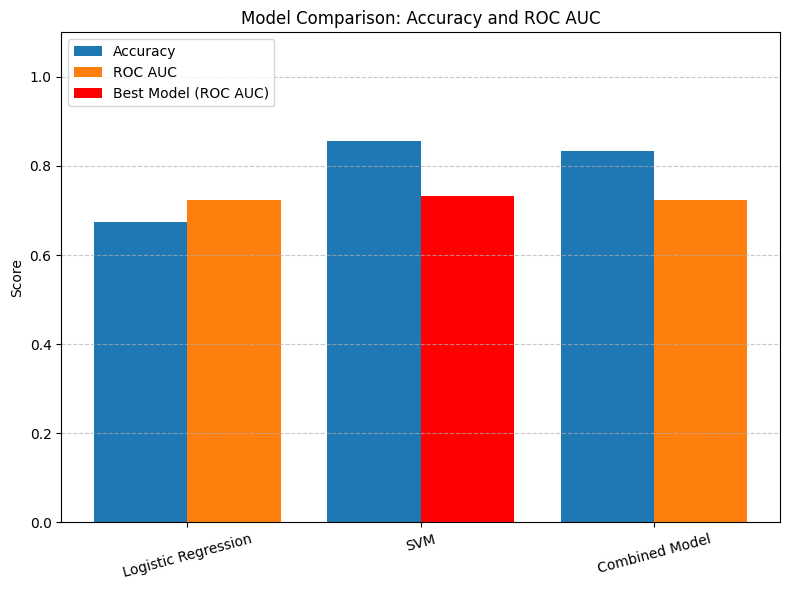

In [9]:

from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# ─── Recompute ROC AUC and Accuracy for All Models ─────────────────────────────

model_metrics = {
    "Logistic Regression": {
        "Accuracy": accuracy_score(
            y_test_rf,
            (logistic_pipeline.predict_proba(X_test_top)[:, 1] >= 0.5).astype(int)
        ),
        "ROC AUC": roc_auc_score(
            y_test_rf,
            logistic_pipeline.predict_proba(X_test_top)[:, 1]
        )
    },
    "SVM": {
        "Accuracy": accuracy_score(
            y_test_rf,
            (svm_pipeline.predict_proba(X_test_top)[:, 1] >= 0.5).astype(int)
        ),
        "ROC AUC": roc_auc_score(
            y_test_rf,
            svm_pipeline.predict_proba(X_test_top)[:, 1]
        )
    },
    "Combined Model": {
        "Accuracy": accuracy_score(
            y_test_rf,
            (ensemble_proba >= 0.5).astype(int)
        ),
        "ROC AUC": roc_auc_score(
            y_test_rf,
            ensemble_proba
        )
    }
}

# Extract metrics for plotting
models = list(model_metrics.keys())
accuracy_scores = [model_metrics[m]["Accuracy"] for m in models]
roc_auc_scores = [model_metrics[m]["ROC AUC"] for m in models]

# Plot comparison
plt.figure(figsize=(8, 6))
x = np.arange(len(models))

plt.bar(x - 0.2, accuracy_scores, width=0.4, label="Accuracy", align='center')
plt.bar(x + 0.2, roc_auc_scores, width=0.4, label="ROC AUC", align='center')

# Highlight best model (by ROC AUC)
best_idx = np.argmax(roc_auc_scores)
plt.bar(
    x[best_idx] + 0.2,
    roc_auc_scores[best_idx],
    width=0.4,
    color='red',
    label="Best Model (ROC AUC)",
    align='center'
)

plt.xticks(x, models, rotation=15)
plt.ylabel("Score")
plt.title("Model Comparison: Accuracy and ROC AUC")
plt.ylim(0, 1.1)
plt.legend(loc="upper left")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



## Threshold Tuning and Confusion Matrix

* **Goal:** Find the optimal decision threshold for Logistic Regression.
* **Steps:**

  * Loop through thresholds from 0.1 to 0.9.
  * Track precision, recall, F1-score.
  * Plot scores vs. threshold.
* **Output:**

  * Confusion matrix at optimal threshold.
  * Better balance between FP and FN achieved.


In [10]:
from lime.lime_tabular import LimeTabularExplainer


# 1. Initialize the LIME explainer
lime_explainer = LimeTabularExplainer(
    training_data=X_train_rf.values,
    feature_names=X_train_rf.columns.tolist(),
    class_names=['No Attrition', 'Attrition'],
    mode='classification'
)

# 2. Choose an instance to explain (e.g. first test row)
instance_index = 0
exp = lime_explainer.explain_instance(
    data_row=X_test_rf.iloc[instance_index].values,
    predict_fn=rf_model.predict_proba,
    num_features=5
)

# 3. Show explanation inline
exp.show_in_notebook()

# 4. Save to HTML for review
exp.save_to_file('lime_explanation.html')
print(f"LIME explanation for test instance {instance_index} saved to 'lime_explanation.html'")


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


LIME explanation for test instance 0 saved to 'lime_explanation.html'


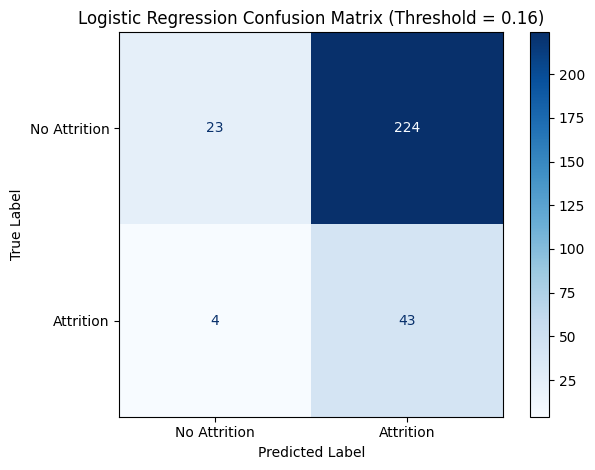

True Negatives (TN):  23
False Positives (FP): 224
False Negatives (FN): 4
True Positives (TP):  43


In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Define threshold and get predicted probabilities
threshold = 0.16
logistic_proba = logistic_pipeline.predict_proba(X_test_top)[:, 1]

# 2. Generate binary predictions at this threshold
logistic_preds = (logistic_proba >= threshold).astype(int)

# 3. Compute confusion matrix
cm = confusion_matrix(y_test_rf, logistic_preds)

# 4. Display confusion matrix
disp = ConfusionMatrixDisplay(cm, display_labels=['No Attrition','Attrition'])
disp.plot(cmap='Blues', colorbar=True)
plt.title(f'Logistic Regression Confusion Matrix (Threshold = {threshold})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.grid(False)
plt.tight_layout()
plt.show()

# 5. Print TN, FP, FN, TP
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (TN):  {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP):  {tp}")


## Evaluation Function and Precision-Recall Curve

* **Function:** `evaluate_model()` built to print metrics and plot ROC + PR curves.
* **Evaluations Done:**

  * Logistic Regression
  * SVM (via `predict_proba`)
  * Weighted ensemble model
* **Outcome:** Compared model effectiveness visually and quantitatively.


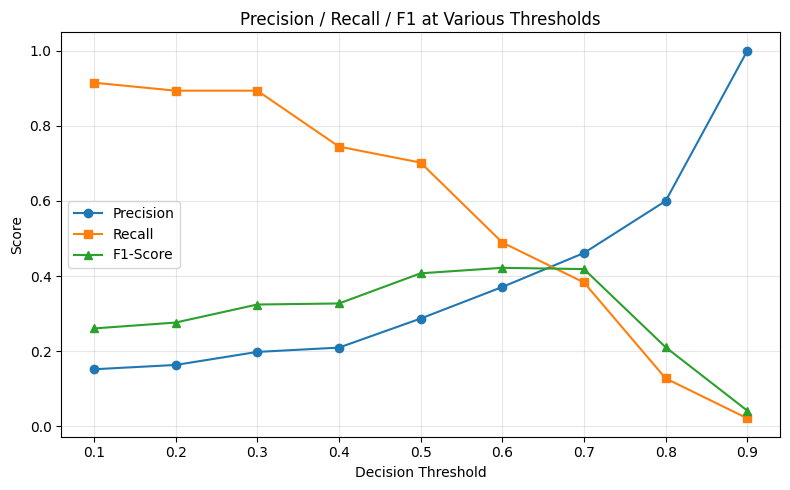

Optimal threshold (max F1): 0.60
 Precision: 0.371
 Recall   : 0.489
 F1-Score : 0.422


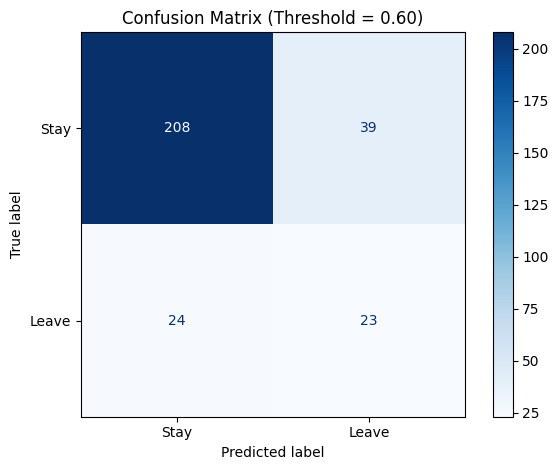

TN: 208, FP: 39, FN: 24, TP: 23


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)

# 1. Get the predicted probabilities once
proba = logistic_pipeline.predict_proba(X_test_top)[:, 1]

# 2. Define thresholds to test
thresholds = np.linspace(0.1, 0.9, 9)

precision_scores = []
recall_scores    = []
f1_scores        = []

for thr in thresholds:
    preds = (proba >= thr).astype(int)
    precision_scores.append(precision_score(y_test_rf, preds, zero_division=1))
    recall_scores.append(recall_score(y_test_rf, preds))
    f1_scores.append(f1_score(y_test_rf, preds))

# 3. Plot Precision / Recall / F1 vs. Threshold
plt.figure(figsize=(8,5))
plt.plot(thresholds, precision_scores, marker='o', label='Precision')
plt.plot(thresholds, recall_scores,    marker='s', label='Recall')
plt.plot(thresholds, f1_scores,        marker='^', label='F1-Score')
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Precision / Recall / F1 at Various Thresholds")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 4. Pick the threshold that maximizes F1 (or another metric)
best_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[best_idx]
print(f"Optimal threshold (max F1): {optimal_threshold:.2f}")
print(f" Precision: {precision_scores[best_idx]:.3f}")
print(f" Recall   : {recall_scores[best_idx]:.3f}")
print(f" F1-Score : {f1_scores[best_idx]:.3f}")

# 5. Confusion matrix at that threshold
final_preds = (proba >= optimal_threshold).astype(int)
cm = confusion_matrix(y_test_rf, final_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=['Stay','Leave'])
disp.plot(cmap='Blues', colorbar=True)
plt.title(f"Confusion Matrix (Threshold = {optimal_threshold:.2f})")
plt.tight_layout()
plt.show()

# 6. Print raw counts
tn, fp, fn, tp = cm.ravel()
print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")


## At-Risk Employee Simulation & Feature Importance

* **Scenario:** Simulate a hypothetical employee with high attrition risk.
* **Steps:**

  * Define dummy employee data using `top_features`.
  * Predict attrition probability using `logistic_pipeline`.
  * Re-train Random Forest to inspect feature importances.
* **Output:** Probability of attrition + feature importance chart.

Predicted attrition likelihood: 97.3%

Random Forest feature importances:
MonthlyIncome        0.143112
DailyRate            0.111716
Age                  0.111280
EmployeeNumber       0.106493
MonthlyRate          0.106278
HourlyRate           0.100327
TotalWorkingYears    0.095842
DistanceFromHome     0.086728
YearsAtCompany       0.085045
OverTime_Yes         0.053178
dtype: float64 



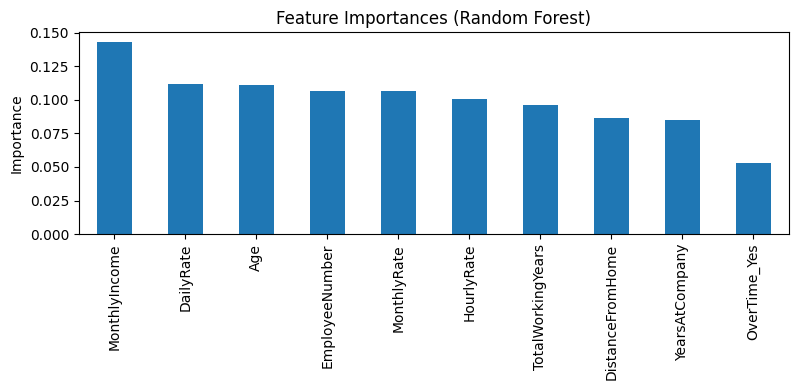

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier


# 1. Define a “dummy” employee using the top_features
dummy_employee1 = pd.DataFrame({
    "MonthlyIncome":     [3000],
    "TotalWorkingYears": [1],
    "Age":               [22],
    "DailyRate":         [800],
    "MonthlyRate":       [10000],
    "HourlyRate":        [40],
    "EmployeeNumber":    [9999],
    "DistanceFromHome":  [29],
    "OverTime_Yes":      [1],
    "YearsAtCompany":    [1]
})

# 2. Add any missing top_features as zeros
for feat in top_features:
    if feat not in dummy_employee1.columns:
        dummy_employee1[feat] = 0

# 3. Re-order columns to match top_features
dummy_employee1 = dummy_employee1[top_features]

# 4. Predict attrition probability with logistic_pipeline
attr_prob1 = logistic_pipeline.predict_proba(dummy_employee1)[:, 1][0]
print(f"Predicted attrition likelihood: {attr_prob1*100:.1f}%\n")

# 5. Fit a Random Forest on the top-feature training set
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_top, y_train_rf)

# 6. Extract and display feature importances
importances = pd.Series(
    rf_model.feature_importances_,
    index=top_features
).sort_values(ascending=False)

print("Random Forest feature importances:")
print(importances, "\n")

plt.figure(figsize=(8, 4))
importances.plot(kind='bar')
plt.title("Feature Importances (Random Forest)")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


In [14]:
# ─── Dummy Profile 2: Mid-career, low risk scenario ───────────────────────────

import pandas as pd

# 1. Build the DataFrame with the same selected_features
dummy_employee2 = pd.DataFrame({
    "MonthlyIncome":           [9000],   # higher salary
    "TotalWorkingYears":       [15],     # seasoned professional
    "Age":                     [45],
    "DailyRate":               [800],
    "MonthlyRate":             [15000],
    "HourlyRate":              [60],
    "EmployeeNumber":          [8888],   # arbitrary ID
    "DistanceFromHome":        [5],      # short commute
    "OverTime_Yes":            [0],      # does not work overtime
    "YearsAtCompany":          [10]      # long tenure
})

# 2. Fill in any missing selected_features with zeros
for feat in top_features:
    if feat not in dummy_employee2.columns:
        dummy_employee2[feat] = 0

# 3. Re-order columns
dummy_employee2 = dummy_employee2[top_features]

# 4. Predict attrition probability
attr_prob2 = logistic_pipeline.predict_proba(dummy_employee2)[:, 1][0]
print(f"Predicted attrition likelihood for Profile 2: {attr_prob2*100:.1f}%")


Predicted attrition likelihood for Profile 2: 50.6%


## Final Thoughts

* This end-to-end pipeline covers preprocessing, feature selection, model evaluation, and interpretability.
* Ensemble methods and threshold tuning were crucial in balancing model performance.
* The analysis provides actionable insights to HR or business stakeholders for proactive attrition management.